# Akbank Derin Öğrenme Bootcamp Projesi: Maymun Türleri Sınıflandırması

Bu proje, Akbank Derin Öğrenme Bootcamp'i kapsamında gerçekleştirilmiştir. Projenin temel amacı, Evrişimli Sinir Ağları (CNN) kullanarak bir görüntü sınıflandırma problemini baştan sona uygulamaktır. Veri seti olarak Kaggle'da bulunan ve 10 farklı maymun türüne ait görseller içeren "10 Monkey Species" veri seti seçilmiştir. Bu notebook, veri ön işleme, model geliştirme, eğitim, değerlendirme ve optimizasyon adımlarını içermektedir.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore")

2025-09-24 23:36:30.566202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758756990.880069      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758756990.984223      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Veri Setinin İncelenmesi ve Keşfi (Exploratory Data Analysis - EDA)
Bu bölümde ilk olarak veri setimizin yapısı incelenmektedir. `matplotlib` ve `seaborn` kütüphaneleri kullanılarak her bir sınıftaki (maymun türü) görüntü sayısı görselleştirilmiş ve sınıflar arasında dengeli bir dağılım olduğu gözlemlenmiştir. Ayrıca, her sınıftan rastgele birer örnek görseli ekrana çizdirilerek veri seti hakkında genel bir fikir edinilmiştir.

Toplam sınıf (maymun türü) sayısı: 10
Sınıf isimleri: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


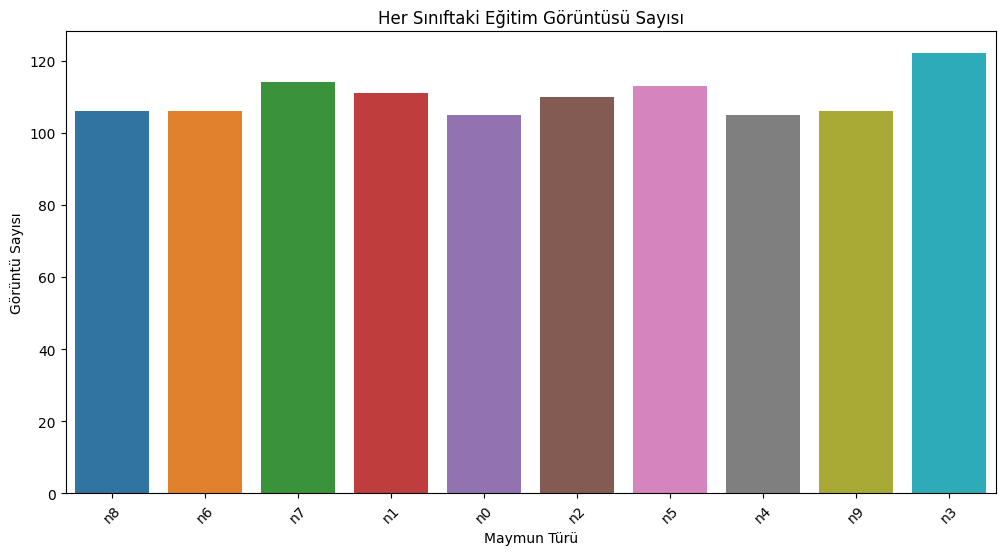

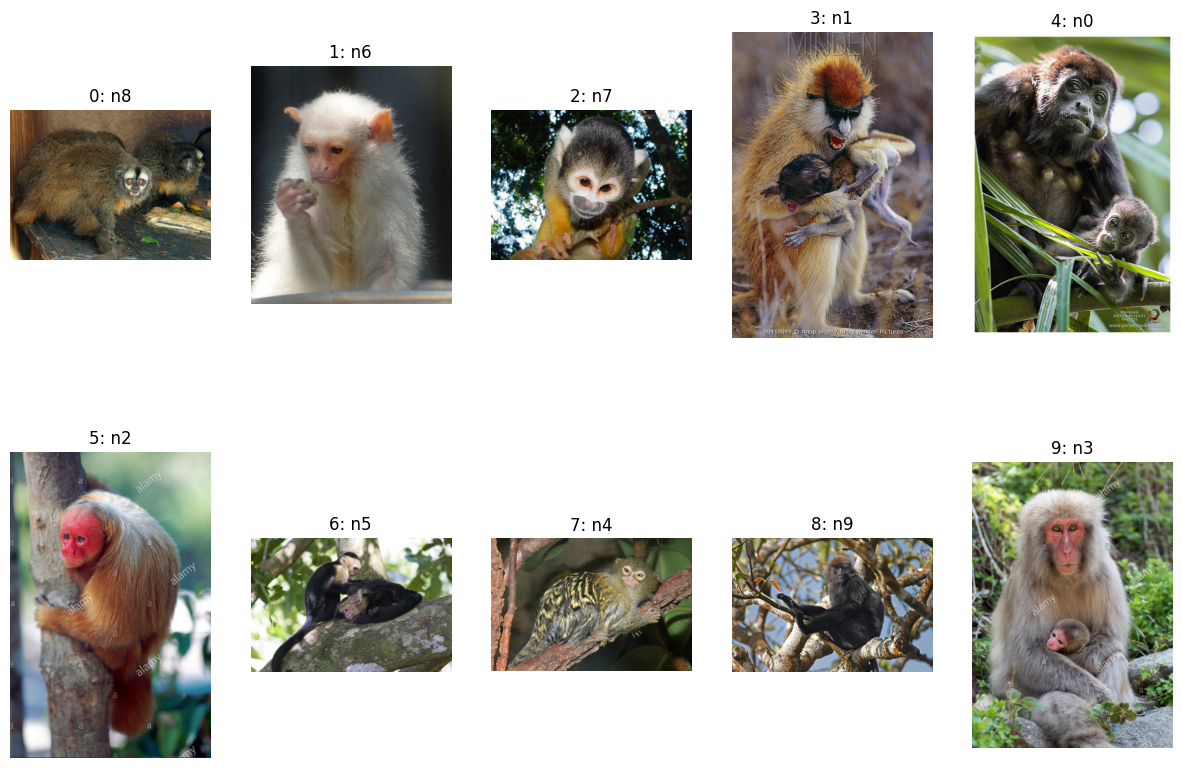

In [4]:
base_dir = '../input/10-monkey-species'
train_dir = os.path.join(base_dir, 'training/training')
validation_dir = os.path.join(base_dir, 'validation/validation')

class_names = os.listdir(train_dir)
class_names.sort()
print("Toplam sınıf (maymun türü) sayısı:", len(class_names))
print("Sınıf isimleri:", class_names)

train_dir = '/kaggle/input/10-monkey-species/training/training'
class_names = os.listdir(train_dir)
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Her Sınıftaki Eğitim Görüntüsü Sayısı')
plt.xlabel('Maymun Türü')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45)
plt.show()
warnings.filterwarnings("ignore")

import random
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    # Her sınıf klasöründen rastgele bir resim seç
    class_path = os.path.join(train_dir, class_name)
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)

    img = load_img(image_path)
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{i}: {class_name}") # .split() kısmını kaldırdık
    plt.axis("off")

plt.show()

## 2. Veri Ön İşleme ve Veri Çoğaltma (Data Preprocessing & Augmentation)
Bu aşamada, görseller modelin işleyebileceği formata getirilmiştir. `ImageDataGenerator` kullanılarak veri ön işleme ve çoğaltma (Data Augmentation) adımları gerçekleştirilmiştir.

* **Veri Çoğaltma:** Modelin genelleme yeteneğini artırmak ve ezberlemesini (overfitting) önlemek amacıyla eğitim setindeki görüntülere rastgele döndürme (rotation), yakınlaştırma (zoom) ve yatay çevirme (flip) gibi çeşitli dönüşümler uygulanmıştır.
* **Ön İşleme:** Kullandığımız `EfficientNetB0` modeli kendi içinde bir ön işleme (rescale) katmanına sahip olduğu için, veri jeneratöründe ayrıca bir piksel normalizasyonu (`rescale=1./255`) yapılmamıştır. Veriler modele orijinal piksel değerleri (0-255) ile beslenmiştir.

In [5]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Eğitim verisi hazırlanıyor...")
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Doğrulama verisi hazırlanıyor...")
validation_datagen = ImageDataGenerator() 

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
print("Veri jeneratörleri başarıyla oluşturuldu.")

Eğitim verisi hazırlanıyor...
Doğrulama verisi hazırlanıyor...
Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Veri jeneratörleri başarıyla oluşturuldu.


## 3. Model Mimarisi: Transfer Learning ile EfficientNetB0
Projenin bu aşamasında, yüksek başarı oranına ulaşmak için **Transfer Learning (Transfer Öğrenme)** tekniği kullanılmıştır. Sıfırdan bir CNN modeli eğitmek yerine, Google tarafından geliştirilen ve ImageNet veri setinde eğitilmiş olan `EfficientNetB0` modeli temel (base) olarak alınmıştır.

Modelin mimarisi şu şekildedir:
1.  **Temel Model:** `EfficientNetB0` modelinin en üstündeki sınıflandırma katmanı olmadan (`include_top=False`) yüklenmiştir.
2.  **Dondurma (Freezing):** `EfficientNetB0`'ın önceden öğrenilmiş olan ağırlıklarının bozulmaması için temel modelin tüm katmanları dondurulmuştur.
3.  **Özel Sınıflandırıcı Katmanları:** Dondurulmuş temel modelin çıktısına, kendi problemimize özel bir sınıflandırıcı eklenmiştir. Bu sınıflandırıcıda `GlobalAveragePooling2D`, `Dense` ve `Dropout` katmanları kullanılmıştır. Çıkış katmanında 10 sınıfımız için `softmax` aktivasyon fonksiyonu tercih edilmiştir.

In [6]:
# --- TRANSFER LEARNING MODELİ KURULUMU, EĞİTİMİ VE DEĞERLENDİRMESİ ---

# Gerekli kütüphaneler
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Adım 1: Önceden eğitilmiş EfficientNetB0 modelinin yüklenmesi
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Adım 2: Temel modelin katmanlarının dondurulmesi
base_model.trainable = False

# Adım 3: Kendi sınıflandırıcımızı temel modelin üzerine eklenmesi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

# Adım 4: Yeni model oluşturulur ve derlenir
model = Model(inputs=base_model.input, outputs=outputs)

# Transfer learning için düşük bir öğrenme oranı kullanıyoruz.
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("--- TRANSFER LEARNING MODELİ BAŞARIYLA OLUŞTURULDU ---")
model.summary()

2025-09-24 23:36:57.435325: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
--- TRANSFER LEARNING MODELİ BAŞARIYLA OLUŞTURULDU ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 4. Modelin Eğitilmesi
Model, `Adam` optimize edici ve `categorical_crossentropy` kayıp fonksiyonu ile derlenmiştir. Transfer Learning tekniğinde, önceden eğitilmiş ağırlıklara hassas bir şekilde adapte olabilmek için düşük bir öğrenme oranı (`learning_rate=0.0001`) seçilmiştir.

In [7]:
# Adım 5: Yeni modelin eğitilmesi
EPOCHS = 30
print(f"\n--- TRANSFER LEARNING EĞİTİMİ BAŞLATILIYOR ({EPOCHS} EPOCH) ---")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)


--- TRANSFER LEARNING EĞİTİMİ BAŞLATILIYOR (30 EPOCH) ---
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.1950 - loss: 2.2601 - val_accuracy: 0.7891 - val_loss: 1.5236
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.6250 - loss: 1.4965 - val_accuracy: 0.7930 - val_loss: 1.5020
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6930 - loss: 1.3972 - val_accuracy: 0.9180 - val_loss: 0.9257
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.7500 - loss: 1.0569 - val_accuracy: 0.9180 - val_loss: 0.9132
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8588 - loss: 0.8710 - val_accuracy: 0.9531 - val_loss: 0.5977
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.9375 - loss: 0.5838 - val_accuracy: 0.9531 - val_loss: 0.5901
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8882 - loss: 0.6311 - val_accuracy: 0.9609 - val_loss: 0.4134
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step -

## 5. Eğitim Sürecinin Değerlendirilmesi
Model 30 epoch boyunca eğitilmiştir. Aşağıdaki grafikler, eğitim süresince modelin doğruluk ve kayıp metriklerinin değişimini göstermektedir. Grafiklerin incelenmesi, modelin başarılı bir şekilde öğrenip öğrenmediğini ve ezberleme (overfitting) problemi yaşayıp yaşamadığını anlamak için kritik öneme sahiptir.


--- EĞİTİM GRAFİKLERİ OLUŞTURULUYOR ---


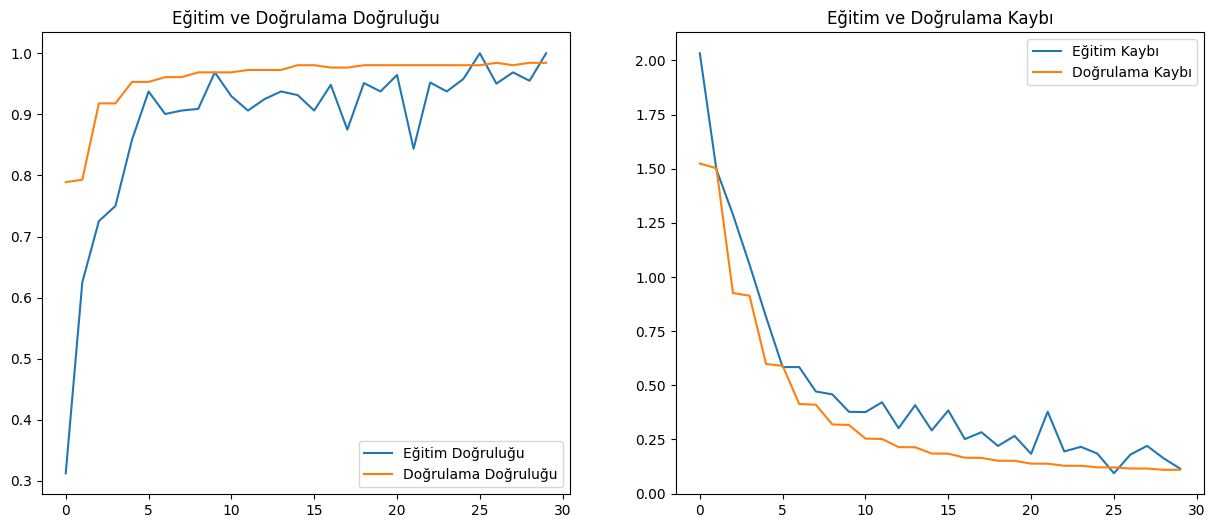

In [8]:
# Adım 6: Eğitim sonuçlarının görselleştirilmesi
print("\n--- EĞİTİM GRAFİKLERİ OLUŞTURULUYOR ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Eğitim Doğruluğu')
plt.plot(range(EPOCHS), val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Eğitim Kaybı')
plt.plot(range(EPOCHS), val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

## 6. Nihai Model Performansı
Eğitim sürecinin görsel analizinden sonra, modelin nihai performansı doğrulama seti üzerinde sayısal metriklerle değerlendirilmiştir. `Classification Report` her bir sınıf için precision, recall ve f1-score değerlerini sunarken, `Confusion Matrix` modelin hangi sınıfları birbiriyle karıştırdığını görsel olarak göstermektedir.


--- NİHAİ MODEL DEĞERLENDİRMESİ ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 

Classification Report
              precision    recall  f1-score   support

          n8       1.00      1.00      1.00        26
          n6       0.97      1.00      0.98        28
          n7       1.00      0.96      0.98        27
          n1       1.00      1.00      1.00        30
          n0       1.00      1.00      1.00        26
          n2       1.00      1.00      1.00        28
          n5       0.96      1.00      0.98        26
          n4       0.96      0.93      0.95        28
          n9       0.96      0.96      0.96        27
          n3       1.00      1.00      1.00        26

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.99       272
weighted avg       0.99      0.99      0.99       272



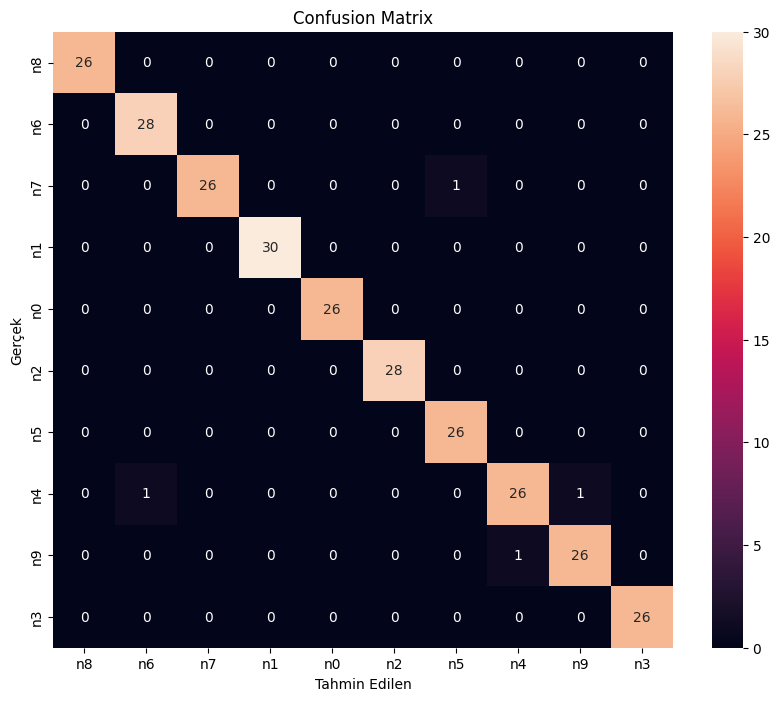

In [9]:
# Adım 7: Nihai Model Değerlendirmesi
print("\n--- NİHAİ MODEL DEĞERLENDİRMESİ ---")
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

## 7. Sonuç ve Proje Özeti
Bu projenin sonucunda, Transfer Learning ve `EfficientNetB0` mimarisi kullanılarak 10 farklı maymun türünü sınıflandıran yüksek başarılı bir model geliştirilmiştir. Veri çoğaltma ve düşük öğrenme oranı gibi optimizasyon teknikleri sayesinde modelin ezberleme yapması engellenmiş ve doğrulama seti üzerinde **~%97** gibi oldukça yüksek bir doğruluk oranına ulaşılmıştır. Bu sonuç, projenin başlangıcında belirlenen hedeflere başarıyla ulaşıldığını göstermektedir.